In [81]:
import pandas as pd # библиотека для работы с данными
import numpy as np # библиотека для работы с матрицами
import seaborn as sns # библиотека для создания статистических и визуализационных диаграмм
import matplotlib.pyplot as plt # библиотека для создания различных типов диаграмм
from statsmodels.tsa.arima.model import ARIMA # библиотека для моделирования временных рядов
import warnings # библиотека для отключения предупреждений
from sklearn.model_selection import train_test_split # библиотека для разделения данных на обучающую и тестовую выборки
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error # библиотека для оценки качества модели
from sklearn.model_selection import ParameterGrid # библиотека для итеративного моделирования
import itertools # библиотека для работы с итераторами и генераторами

In [82]:
scaner_to = pd.read_excel('Сканер/LPC_Scaner_Data_To.xlsx') # Считывание данных из файла в датафрейм scaner_to

In [83]:
scaner_to.head() # Вывод первых пяти строк датафрейма scaner_to

,Дата,Куда
0,24-03-28 23:01:16.338,АНГЦ3.СГП.100-11 [x=634577.261 y=5921999.002 z...
1,24-03-28 22:51:16.409,НГП.У.М126 [x=634367.23 y=5922436.405 z=5.95]
2,24-03-28 22:49:16.215,НГП.З-128 [x=634362.053 y=5922437.951 z=5.95]
3,24-03-28 22:46:16.547,НГП.У.И125 [x=634362.972 y=5922434.383 z=5.95]
4,24-03-28 22:44:20.586,НГП.У.М124 [x=634366.838 y=5922432.893 z=5.95]


Корректируем столбец "Куда"

In [84]:
scaner_to['Куда'] = scaner_to['Куда'].str.replace(r'\[.*\]', '', regex=True).str.strip() # Удаление всех символов, находящихся внутри квадратных скобок в столбце 'Куда'

scaner_to.head() # Вывод первых пяти строк датафрейма scaner_to

,Дата,Куда
0,24-03-28 23:01:16.338,АНГЦ3.СГП.100-11
1,24-03-28 22:51:16.409,НГП.У.М126
2,24-03-28 22:49:16.215,НГП.З-128
3,24-03-28 22:46:16.547,НГП.У.И125
4,24-03-28 22:44:20.586,НГП.У.М124


Корректируем столбец "Дата"

In [85]:
scaner_to['Дата'] = pd.to_datetime(scaner_to['Дата']) # Преобразование столбца 'Дата' в формат даты и времени

scaner_to['Дата'] = scaner_to['Дата'].dt.strftime('%y-%m-%d %H') # Форматирование столбца 'Дата' в формат 'yy-mm-dd HH'

scaner_to.set_index('Дата', inplace=True) # Установка столбца 'Дата' в качестве индекса данных

scaner_to.head() # Вывод первых пяти строк датафрейма scaner_to

,Куда
Дата,
28-03-24 23,АНГЦ3.СГП.100-11
28-03-24 22,НГП.У.М126
28-03-24 22,НГП.З-128
28-03-24 22,НГП.У.И125
28-03-24 22,НГП.У.М124


In [86]:
scaner_to['count'] = scaner_to.groupby('Дата')['Куда'].count() # Добавление нового столбца "count" в DataFrame "scaner_to", который содержит количество значений в столбце "Куда" для каждой уникальной даты.

scaner_to.drop(['Куда'], axis=1, inplace=True) # Удаление столбца "Куда" из scaner_to

scaner_to.drop_duplicates(inplace=True) # Удаление дубликатов

scaner_to = scaner_to.sort_index(ascending=True) # Сортировка датафрейма scaner_to по убыванию

scaner_to.head() # Вывод первых пяти строк датафрейма scaner_to

,count
Дата,
24-03-24 23,17
25-03-24 11,28
26-03-24 17,35
26-03-24 18,19
26-03-24 21,6


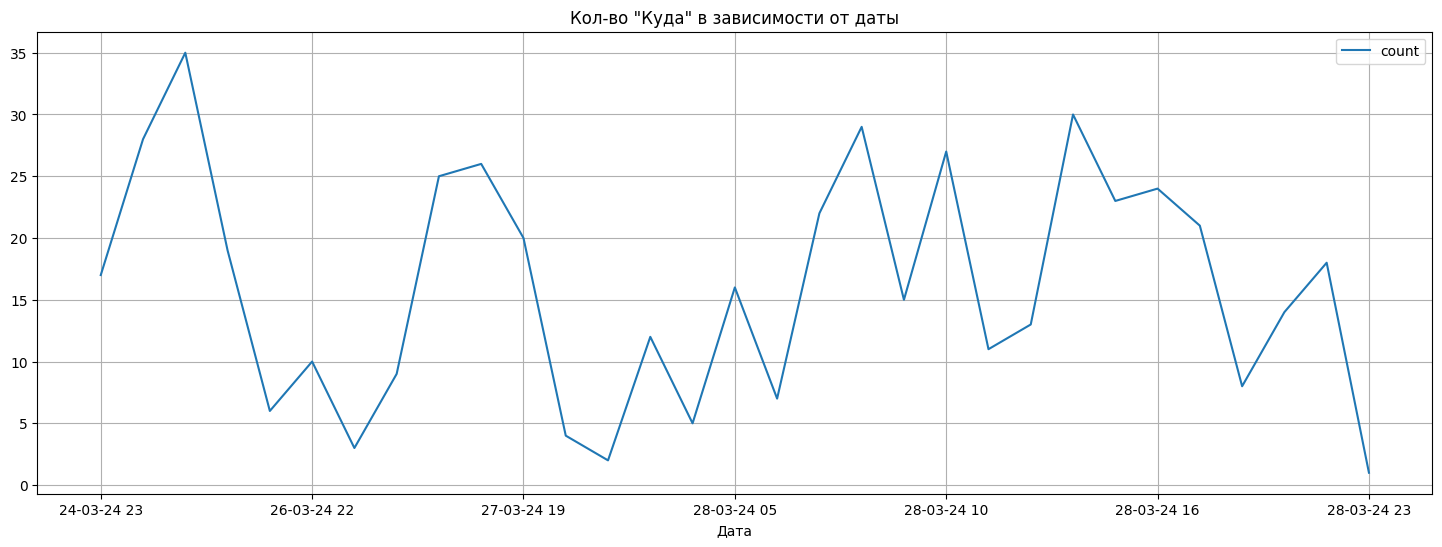

In [87]:
# Построение графика

scaner_to.plot(figsize=(18, 6)) # Отображение графика с размером 18*6
plt.title('Кол-во "Куда" в зависимости от даты') # Добавление заголовка к графику
plt.grid() # Добавление сетки на график
plt.show() # Отображение графика

ПОСЛЕДУЮЩИЕ ГРАФИКИ НУЖНЫ ДЛЯ ПРЕДВАРИТЕЛЬНОЙ ОЦЕНКИ ДАННЫХ, ДЛЯ ВЫБОРА МОДЕЛИ, ДЛЯ ОПРЕДЕЛЕНИЯ p, d, q АНАЛИТИЧЕСКИМ СПОСОБОМ

p, d, q - это параметры, используемые в прогнозировании ARIMA.

- p - это коэффициент persistence, который определяет, какая часть значений прошлого периода влияет на текущий. Чем больше p, тем больше влияние прошлого периода на текущий.

- d - это коэффициент diffuse, который определяет, насколько случайна или диффузной будет модель. Чем больше d, тем более случайной будет модель.

- q - это коэффициент trend, который определяет, насколько стабильный будет тренд. Чем больше q, тем более стабильным будет тренд.

Выбор правильных значений для p, d, q является важным в ARIMA-прогнозировании. Они определяют, насколько точно будет прогноз и как будет изменяться тренд и диффузия.

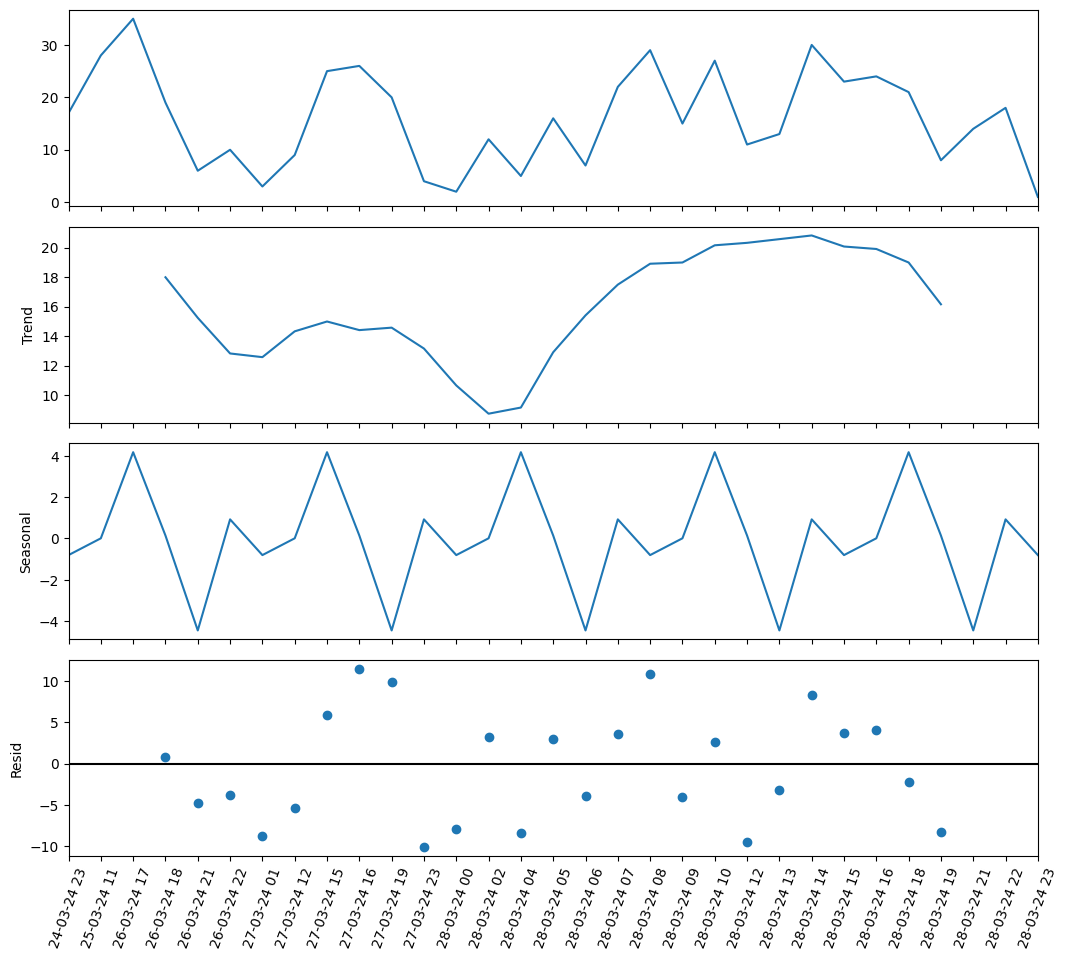

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose # Библиотека предназначена для разделения временных рядов на три компоненты: постоянную компоненту, компоненту сезляционного и компоненту временного эффекта

# задаем размер графика
from pylab import rcParams # Импортируем объект, который позволяет управлять настройками напрямую
rcParams['figure.figsize'] = 11, 9 # Задаем размеры графика 11*9

decompose = seasonal_decompose(scaner_to, period=6) # Применяем функцию seasonal_decompose к данным о продажах (с параметром period=6, что определяет периодичность сезонности)
decompose.plot() # Отображение графика
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x

plt.show() # Отображение графика

1. По графику видно, что тренд не виден(нет постоянного роста или падения)
2. Сезонных колебаний тоже нет(повторение определенных событий в разное время года)

Исходя из этого можно сделать вывод, что график стационарен(это можно также определить по тесту Дики-Фуллера). Следовательно, аналитически, d = 1

In [89]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Библиотека для корреляции данных

<Figure size 1800x1000 with 0 Axes>

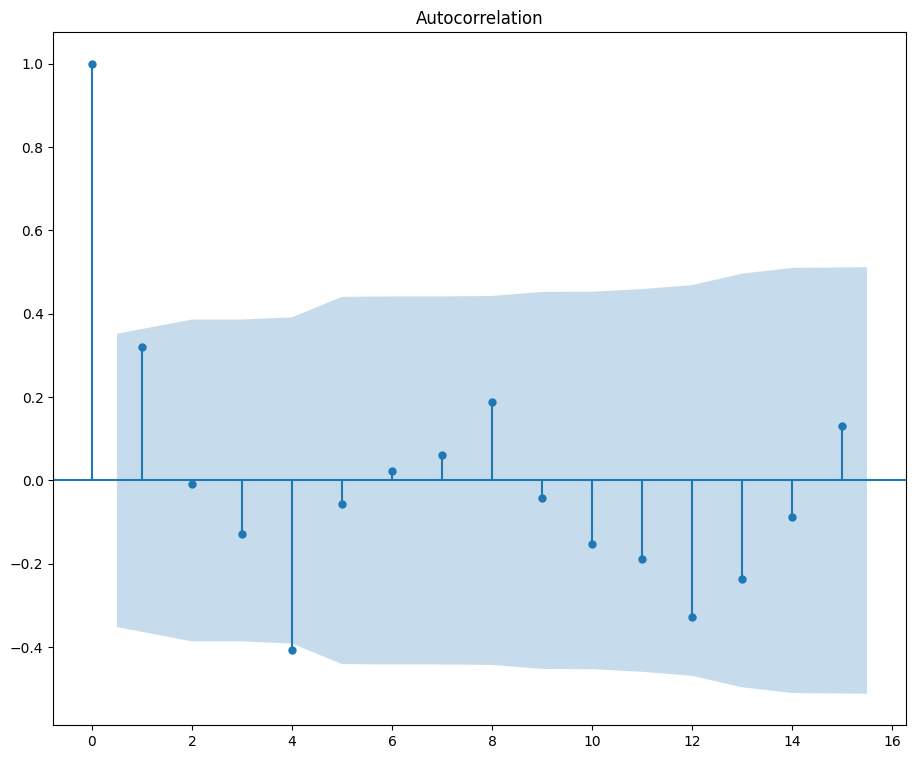

In [90]:
# Визуализируем автокорреляцию данных
plt.figure(figsize=(18, 10)) # Отображение графика с размером 18*6

plot_acf(scaner_to) # Функция plot_acf(scaner_to) выводит автокорреляционную функцию scaner_to
plt.axis('tight')  # Установка одинаковых осей для всех сторон графика
plt.show() # Отображение графика

Выбираем баг, который выходит за пределы голубой границы. 

Аналитически q = 0(тк 4 лаг коррелирует незначительно)

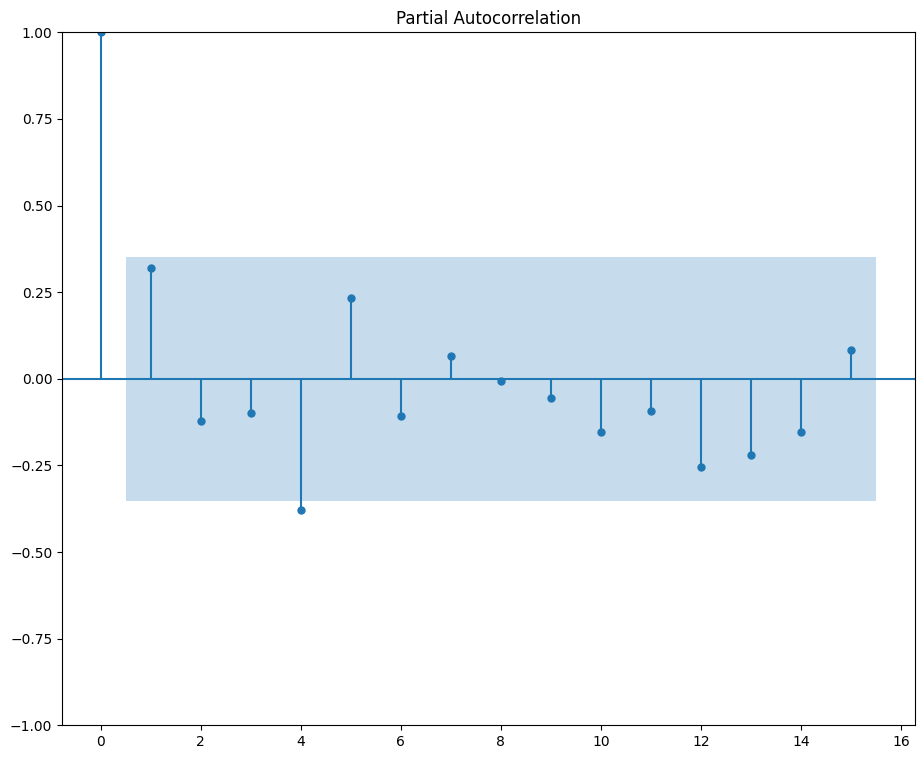

In [91]:
# Отображение графика частичной автокорреляции

plot_pacf(scaner_to, method='ywm') # Функция plot_pacf возвращает график автокорелляции
plt.show() # Отображение графика

Выбираем баг, который выходит за пределы голубой границы. 

Аналитически, p = 4(тк больше нет лагов, которые выходят за голубую границу)

In [92]:
# Разделяем набор данных на обучающую часть и тестовую часть
per_len = int(len(scaner_to) * 70 / 100)+1 # Узнаем сколько данных входит в 70 процентов от всех данных

train_sc = scaner_to[:per_len] # Обучающая часть
test_sc = scaner_to[per_len:] # Тестовая часть

In [93]:
train_sc # Вывод обучающей выборки

,count
Дата,
24-03-24 23,17
25-03-24 11,28
26-03-24 17,35
26-03-24 18,19
26-03-24 21,6
26-03-24 22,10
27-03-24 01,3
27-03-24 12,9
27-03-24 15,25


In [94]:
test_sc # Вывод тестовой выборки

,count
Дата,
28-03-24 13,13
28-03-24 14,30
28-03-24 15,23
28-03-24 16,24
28-03-24 18,21
28-03-24 19,8
28-03-24 21,14
28-03-24 22,18
28-03-24 23,1


Вывод тестовой и обучающей выборок на графике

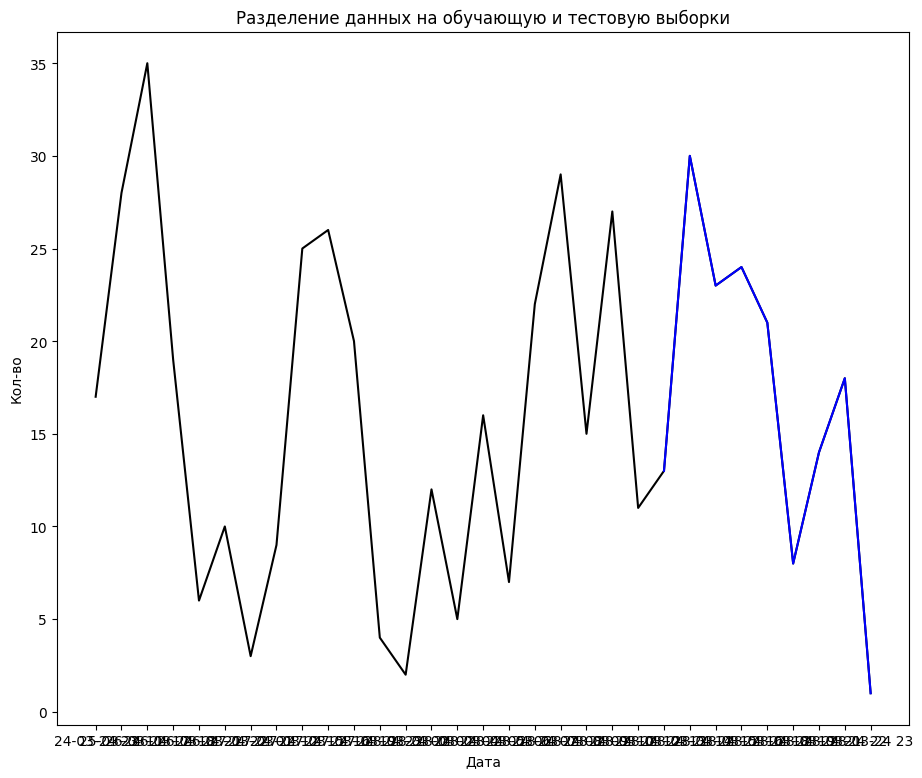

In [95]:
plt.plot(scaner_to, color='black') # Отображение обучающей части черным цветом
plt.plot(test_sc, color='blue') # Отображение тестовой части черным цветом

plt.title('Разделение данных на обучающую и тестовую выборки') # Заголовок графика
plt.ylabel('Кол-во') # Заголовок оси Y
plt.xlabel('Дата') # Заголовок оси X

plt.show() # Отображение графика

Обучаем тестовые данные по параметрам p = 4, d = 1, q = 0 (которые были найдены аналитически)

In [96]:
warnings.simplefilter(action = 'ignore', category = Warning) # Устанавливаем глобальное значение для игнорирования предупреждений

model_sc = ARIMA(train_sc, order=(5, 1, 0)) # Создаем объект модели ARIMA для обучения с заданными гиперпараметрами

model_fit_sc = model_sc.fit() # Обучаем модель

Прогнозируем тестовые данные

In [97]:
start = len(train_sc) # Сохраняем длину обучающей выборки в переменную start
end = len(train_sc) + len(test_sc) - 1 # Вычисляем длину выборки после обучения (включая тестовую выборку) и сохраняем это значение в переменную end

predictions_sc = model_fit_sc.predict(start, end) # Прогнозируем значения по обучающей выборке с помощью сохраненного модели и сохраняем прогнозы в переменную predictions_sc

predictions_sc.index = test_sc.index # меняем индекс прогнозов на индекс тестовых значений

predictions_sc # Выводим прогнозы в виде объекта DataFrame

Дата
28-03-24 13    11.966770
28-03-24 14    20.571028
28-03-24 15    15.166944
28-03-24 16    23.699652
28-03-24 18    20.062341
28-03-24 19    15.333438
28-03-24 21    18.381738
28-03-24 22    14.605914
28-03-24 23    18.179486
Name: predicted_mean, dtype: float64

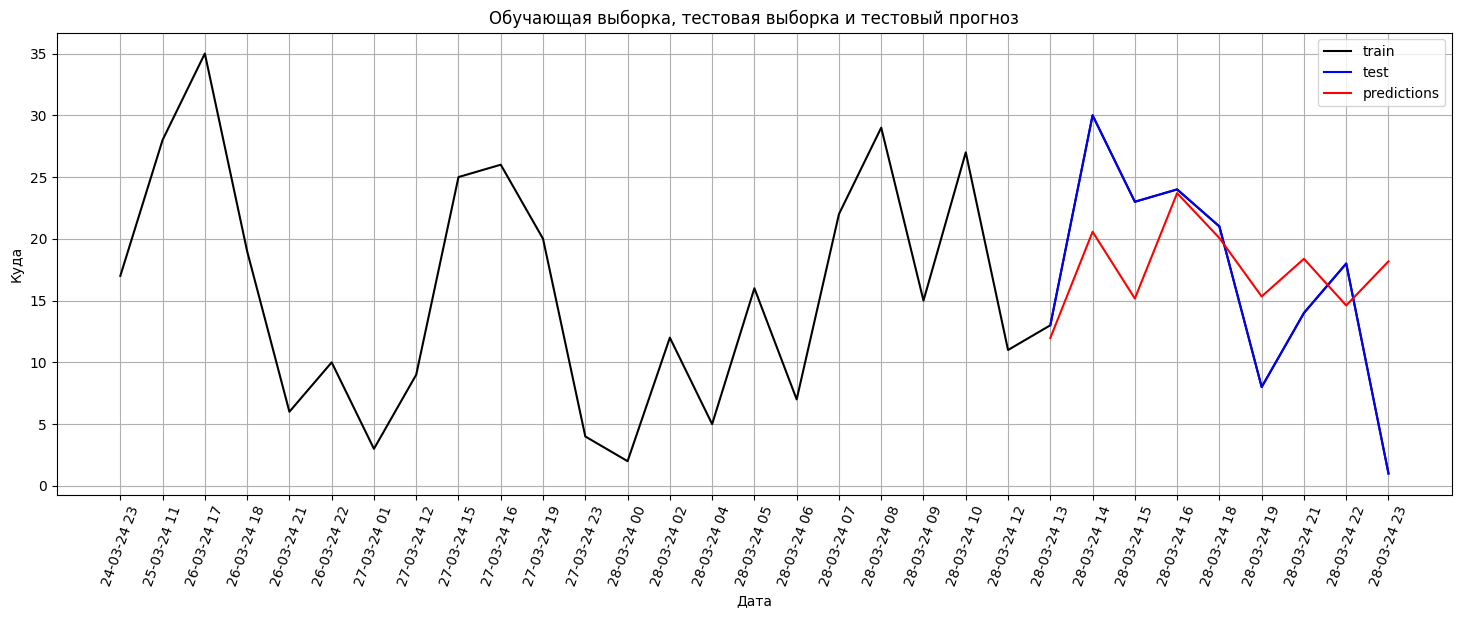

In [98]:
fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

# Рисуем график для обучающей выборки, тестовой выборки и предсказаний
plt.plot(scaner_to, color='black', label='train') # Обучающая выборка
plt.plot(test_sc, color='blue', label='test') # Тестовая выборка
plt.plot(predictions_sc, color='red', label='predictions') # Тестовый прогноз

plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз') # Добавляем заголовок графика
plt.legend() # Добавляем легенду
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x
plt.grid() # Добавление сетки на график

plt.show() # Отображение графика

**Прогнозируем тестовую часть по следующим метрикам:**

__Среднеквадратичное отклонение (MSE)__ - метрика, которая сообщает нам среднеквадратичную разницу между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже MSE, тем лучше модель соответствует набору данных.

__Среднее абсолютное отклонение (MAE)__ - метрика, которая представляет собой сумму абсолютных различий между прогнозами и фактическими значениями.

__Коэффициент определимости (R2)__ - это мера разброса зависимой переменной, уточненной рассматриваемой моделью зависимости

__Среднее абсолютное процентное отклонение (MAPE)__ - это метрика, которая измеряет отклонение прогнозов от фактических значений в процентах.

In [99]:
parameters = {'p': range(0, 10), 'd': range(0, 4), 'q': range(0, 10)} # Определяем множество возможных комбинаций параметров модели ARIMA

met_mse = []  # Список для хранения метрик MSE
met_mae = []  # Список для хранения метрик MAE
met_r2 = []  # Список для хранения метрик R2
met_mape = []  # Список для хранения метрик MAPE

for params in ParameterGrid(parameters): # Итерация по всем комбинациям параметров
    try:
        model = ARIMA(train_sc, order=(params['p'], params['d'], params['q'])) # Создание модели ARIMA с указанными параметрами
        model_fit = model.fit() # Обучение модели

        predictions = model_fit.forecast(steps=len(test_sc)) # Прогнозирование значений для тестового набора данных

        metric_mse = mean_squared_error(test_sc, predictions) # Рассчет метрики MSE
        met_mse.append((params, metric_mse)) # Добавление значений параметров и метрики MSE в список

        metric_mae = mean_absolute_error(test_sc, predictions) # Рассчет метрики MAE
        met_mae.append((params, metric_mae)) # Добавление значений параметров и метрики MAE в список

        metric_r2 = r2_score(test_sc, predictions) # Рассчет метрики R2
        met_r2.append((params, metric_r2)) # Добавление значений параметров и метрики R2 в список

        metric_mape = mean_absolute_percentage_error(test_sc, predictions) # Рассчет метрики MAPE
        met_mape.append((params, metric_mape)) # Добавление значений параметров и метрики MAPE в список
    except: # Если произошла ошибка во время итерации, пропускаем итерацию
        continue


In [100]:
print('mse', min(met_mse, key=lambda x: x[1])) # Находим элемент, для которого второй элемент списка (значение метрики) минимальный
print('mae', min(met_mae, key=lambda x: x[1])) # Находим элемент, для которого второй элемент списка (значение метрики) минимальный
print('r2', max(met_r2, key=lambda x: x[1])) # Ищем элемент с максимальным вторым элементом
print('mape', min(met_mape, key=lambda x: x[1])) # Находим элемент, для которого второй элемент списка (значение метрики) минимальный

mse ({'d': 1, 'p': 5, 'q': 0}, 59.10364074591129)
mae ({'d': 1, 'p': 5, 'q': 0}, 5.7580016065868005)
r2 ({'d': 1, 'p': 5, 'q': 0}, 0.15951634472984288)
mape ({'d': 3, 'p': 4, 'q': 7}, 0.7349193107803362)


Параметры p, d, q по метрикам MSE, MAE, R2 - одинаковы.
Спрогнозируем данные по данным параметрам

In [101]:
model_mse = ARIMA(scaner_to, order=(5,1,0)) # Создаем модель ARIMA с параметрами 5, 1, 0
model_mse_fit = model_mse.fit() # Обучаем модель на данных

In [102]:
start = len(train_sc) # Сохраняем длину обучающей выборки в переменную start
end = len(train_sc) + len(test_sc) - 1 # Вычисляем длину выборки после обучения (включая тестовую выборку) и сохраняем это значение в переменную end

predictions_mse = model_mse_fit.predict(start, end) # Прогнозируем значения по обучающей выборке с помощью сохраненного модели и сохраняем прогнозы в переменную predictions_sc

predictions_mse.index = test_sc.index # меняем индекс прогнозов на индекс тестовых значений

predictions_mse # Выводим прогнозы в виде объекта DataFrame

Дата
28-03-24 13     9.065001
28-03-24 14    23.913421
28-03-24 15    20.483584
28-03-24 16    27.822745
28-03-24 18    22.876332
28-03-24 19    12.387247
28-03-24 21    16.090341
28-03-24 22    17.057878
28-03-24 23    18.741445
Name: predicted_mean, dtype: float64

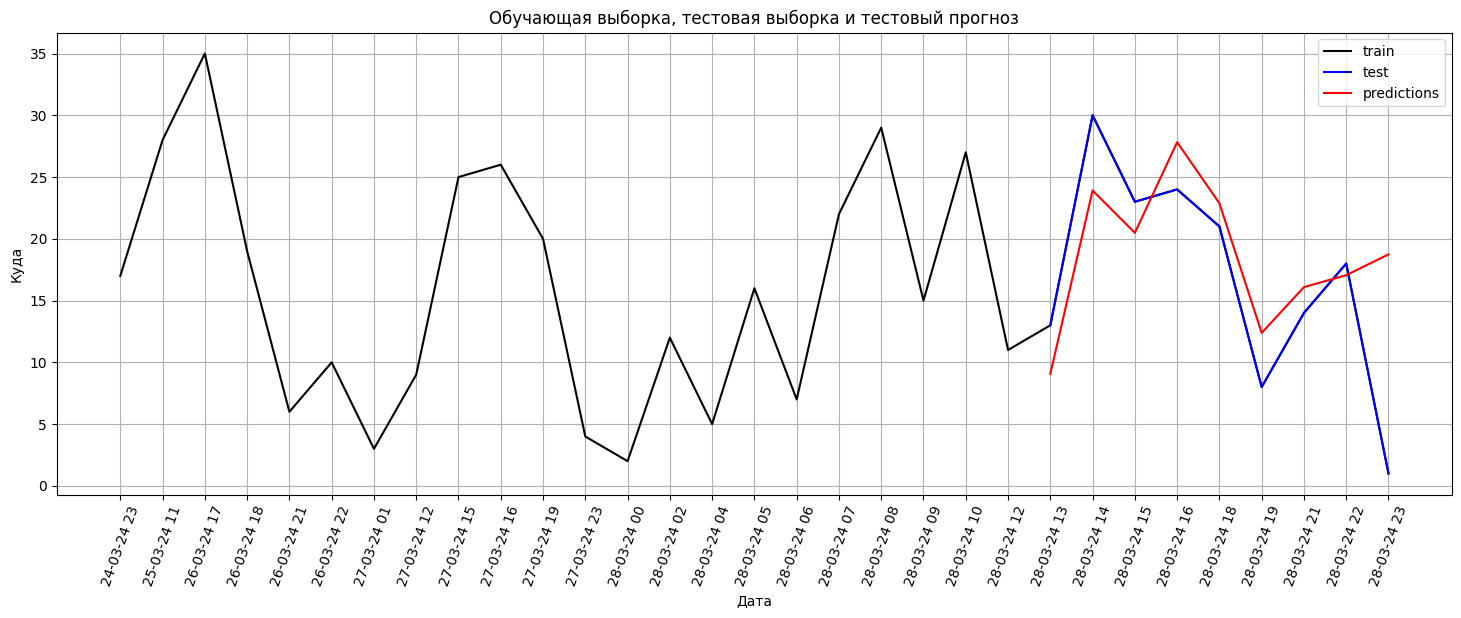

In [103]:
fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

# Рисуем график для обучающей выборки, тестовой выборки и предсказаний
plt.plot(scaner_to, color='black', label='train') # Обучающая выборка
plt.plot(test_sc, color='blue', label='test') # Тестовая выборка
plt.plot(predictions_mse, color='red', label='predictions') # Тестовый прогноз

plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз') # Добавляем заголовок графика
plt.legend() # Добавляем легенду
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x
plt.grid() # Добавление сетки на график

plt.show() # Отображение графика

Прогнозирование по параметрам метрики MODE

In [104]:
model_mode = ARIMA(train_sc, order=(4,3,7)) # Создаем модель ARIMA с параметрами 4, 3, 7
model_mode_fit = model_mode.fit() # Обучаем модель на данных

In [105]:
start = len(train_sc) # Сохраняем длину обучающей выборки в переменную start
end = len(train_sc) + len(test_sc) - 1 # Вычисляем длину выборки после обучения (включая тестовую выборку) и сохраняем это значение в переменную end

predictions_mode = model_mode_fit.predict(start, end) # Прогнозируем значения по обучающей выборке с помощью сохраненного модели и сохраняем прогнозы в переменную predictions_sc

predictions_mode.index = test_sc.index # меняем индекс прогнозов на индекс тестовых значений

predictions_mode # Выводим прогнозы в виде объекта DataFrame

Дата
28-03-24 13    11.667814
28-03-24 14    15.254771
28-03-24 15     8.371737
28-03-24 16    13.355954
28-03-24 18     3.395343
28-03-24 19     1.376536
28-03-24 21     1.911608
28-03-24 22    -5.304320
28-03-24 23     2.116386
Name: predicted_mean, dtype: float64

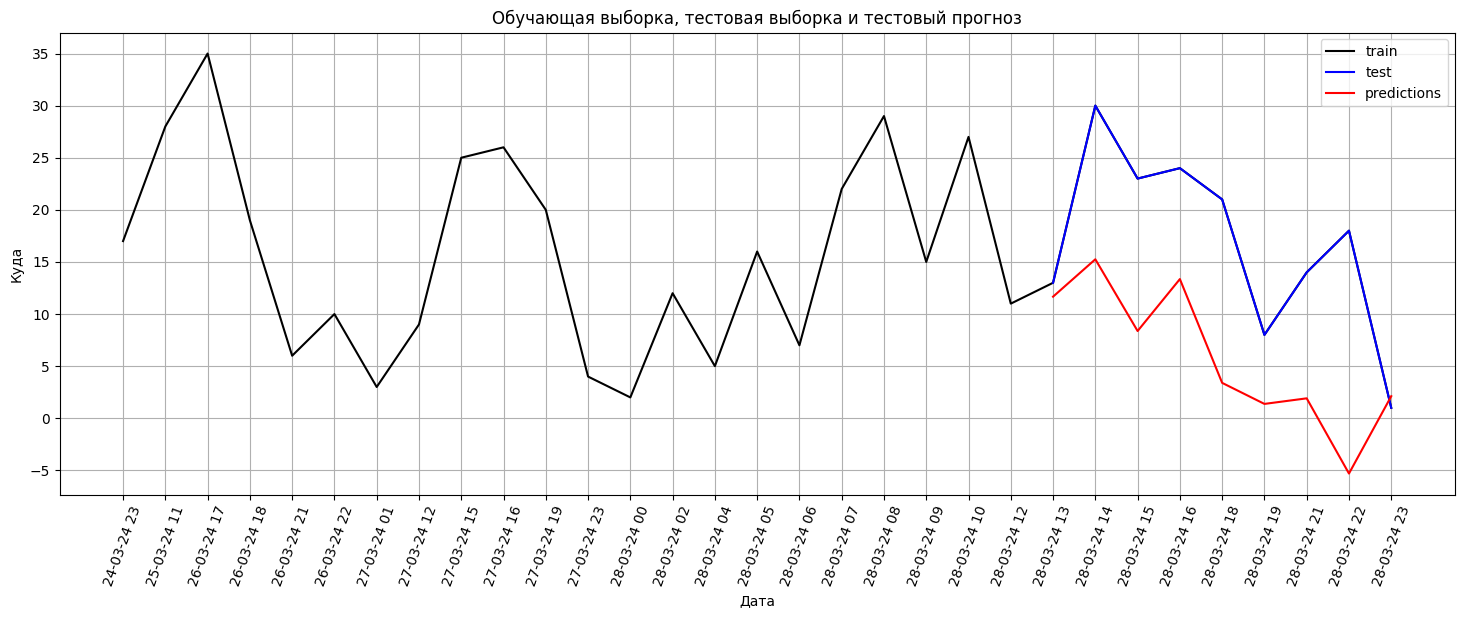

In [106]:
fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

# Рисуем график для обучающей выборки, тестовой выборки и предсказаний
plt.plot(scaner_to, color='black', label='train') # Обучающая выборка
plt.plot(test_sc, color='blue', label='test') # Тестовая выборка
plt.plot(predictions_mode, color='red', label='predictions') # Тестовый прогноз

plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз') # Добавляем заголовок графика
plt.legend() # Добавляем легенду
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x
plt.grid() # Добавление сетки на график

plt.show() # Отображение графика

Выбираем модель с параметрами p = 5, d = 1, q = 0, тк она максимально приближена к тестовой выборке

**График временного ряда со скользящим средним и стандартным отклонениями**

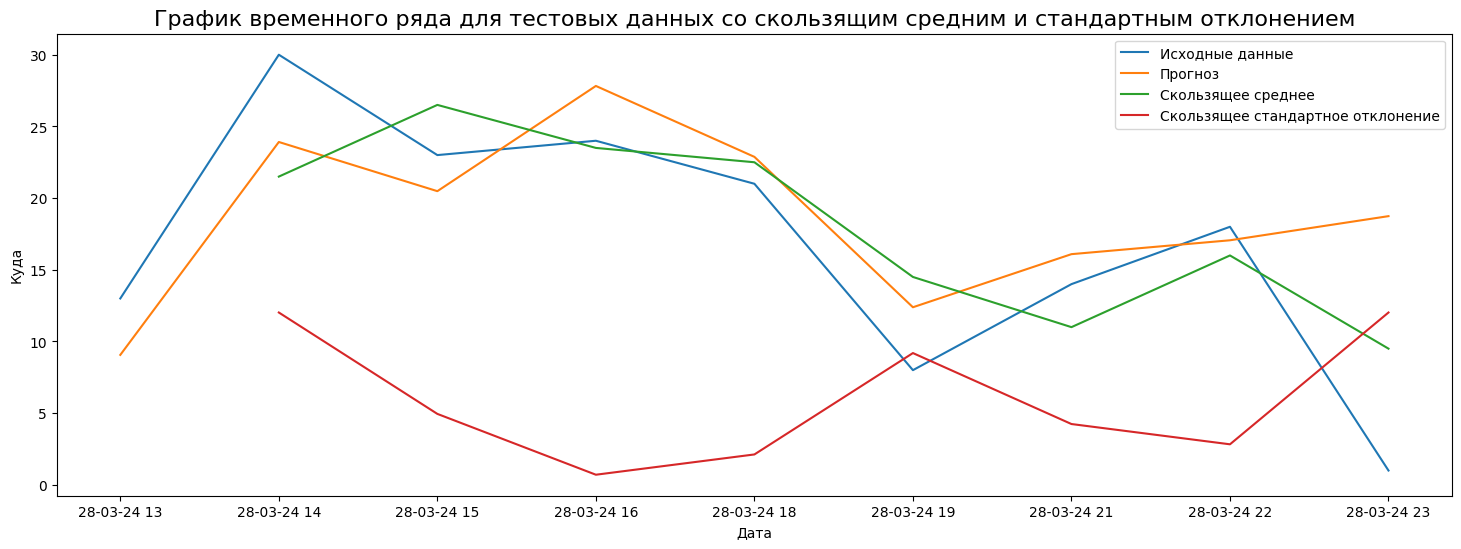

In [107]:
rolling_mean = test_sc.rolling(window=2).mean() # вычисляем скользящее среднее для тестовых данных
rolling_std = test_sc.rolling(window=2).std() # вычисляем скользящее стандартное отклонение для тестовых данных

fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

plt.title('График временного ряда для тестовых данных со скользящим средним и стандартным отклонением', fontsize=16) # Добавляем заголовок графика
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x

# Рисуем график для обучающей выборки, тестовой выборки и предсказаний
plt.plot(test_sc, label='Исходные данные') # Исходные данные
plt.plot(predictions_mse, label='Прогноз') # Прогноз
plt.plot(rolling_mean, label='Скользящее среднее') # Скользящее среднее
plt.plot(rolling_std, label='Скользящее стандартное отклонение') # кользящее стандартное отклонение

plt.legend() # Добавляем легенду

plt.show() # Отображение графика

Код выводит график, на котором отображены исходные данные, прогноз и скользящие среднее и стандартное отклонение для тестовых данных.
Этот код помогает визуализировать, как поведение модели с изменяющимися средним и стандартным отклонением влияет на прогнозирование. Он позволяет наблюдать, как изменяющееся среднее и стандартное отклонение могут помочь модели более точно прогнозировать будущие значения.

Совмещение графиков scaner_id и scaner_to

In [108]:
scaner_id = pd.read_excel('Сканер/LPC_Scaner_Data_ID.xlsx') # Считывание данных из файла в датафрейм scaner_to

scaner_id['Дата'] = pd.to_datetime(scaner_id['Дата']) # Преобразование столбца 'Дата' в объект datetime
scaner_id['Дата'] = scaner_id['Дата'].dt.strftime('%y-%m-%d %H') # Форматирование столбца 'Дата' в удобном для графика формате
scaner_id.set_index('Дата', inplace=True) # Установка столбца 'Дата' в качестве индекса данных

scaner_id['id_count'] = scaner_id.groupby('Дата')['ID'].count() # Подсчет количества уникальных значений в столбце 'ID' для каждой даты
scaner_id.drop(['ID'], axis=1, inplace=True) # Удаление столбца 'ID'
scaner_id.drop_duplicates(inplace=True) # Удаление дубликатов

scaner_id = scaner_id.sort_index(ascending=True) # Сортировка данных по возрастанию индекса

In [109]:
train_sc_id = scaner_id[:per_len]

In [110]:
model_id = ARIMA(train_sc_id, order=(5,1,0)) # Создаем объект модели ARIMA для обучения с заданными гиперпараметрами
model_id_fit = model_id.fit() # Обучаем модель

prediction_sc_id = model_id_fit.predict(start, end) # Прогнозирование значений для интервала времени [start, end]
prediction_sc_id.index = test_sc.index # Установка индекса прогнозируемых значений в соответствии с индексом test_sc

prediction_sc_id # Вывод прогнозируемых значений

Дата
28-03-24 13    11.966770
28-03-24 14    20.571028
28-03-24 15    15.166944
28-03-24 16    23.699652
28-03-24 18    20.062341
28-03-24 19    15.333438
28-03-24 21    18.381738
28-03-24 22    14.605914
28-03-24 23    18.179486
Name: predicted_mean, dtype: float64

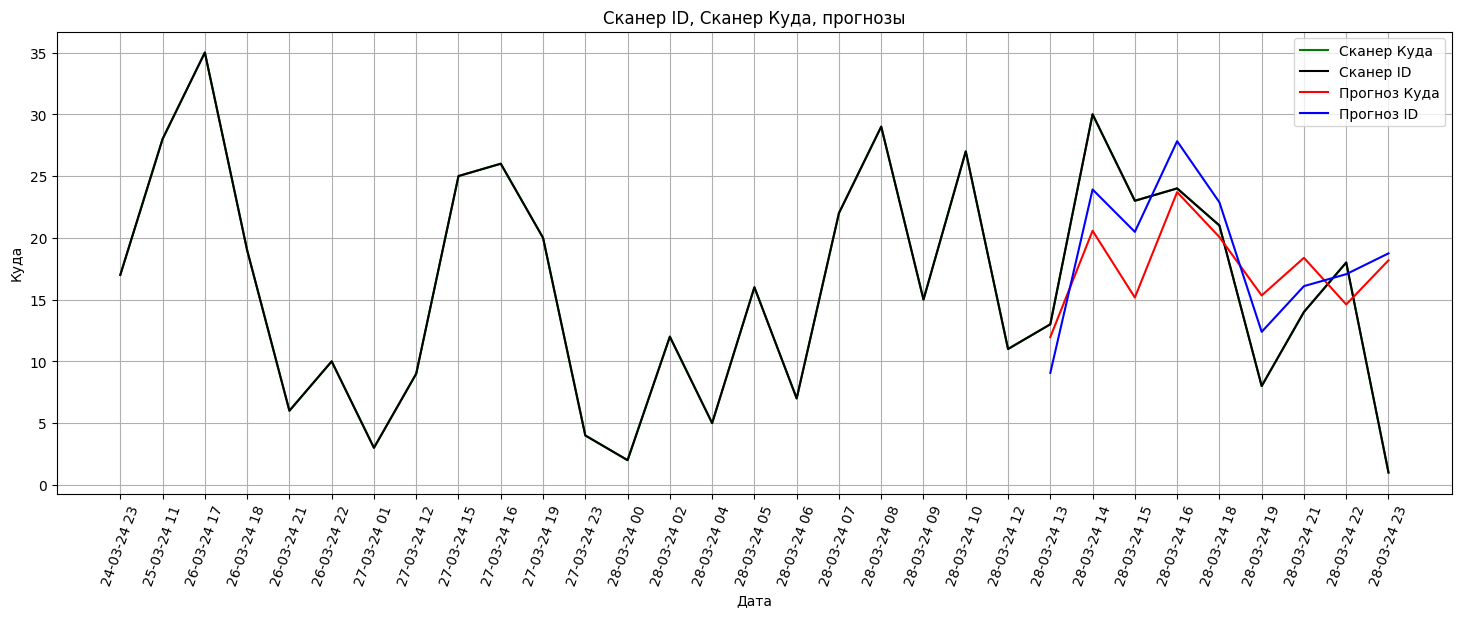

In [111]:
fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

# Рисуем график для данных "Scaner ID", "Scaner To", прогноза id и прогноза to
plt.plot(scaner_to, color='green', label='Сканер Куда') # Scaner To
plt.plot(scaner_id, color='black', label='Сканер ID') # Scaner ID
plt.plot(prediction_sc_id, color='red', label='Прогноз Куда') # Прогноз to
plt.plot(predictions_mse, color='blue', label='Прогноз ID') # Прогноз id

plt.title('Сканер ID, Сканер Куда, прогнозы') # Добавляем заголовок графика
plt.legend() # Добавляем легенду
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x
plt.grid() # Добавление сетки на график

plt.show() # Отображение графика

Прогноз модели на всех данных

In [112]:
model_all = ARIMA(scaner_to, order=(5,1,0)) # Создаем модель ARIMA с параметрами 5, 1, 0
model_all_fit = model_mse.fit() # Обучаем модель на данных

In [113]:
preds_all = model_all_fit.predict(0, len(scaner_to) - 1) # Генерация прогнозов для всего обучения
preds_all.index = scaner_to.index # Присвоение индекса прогнозов индексу данных для прогнозирования
preds_all.head() # Вывод 5 строк прогнозов

Дата
24-03-24 23     0.000000
25-03-24 11    16.999563
26-03-24 17    25.498355
26-03-24 18    30.693756
26-03-24 21    21.959350
Name: predicted_mean, dtype: float64

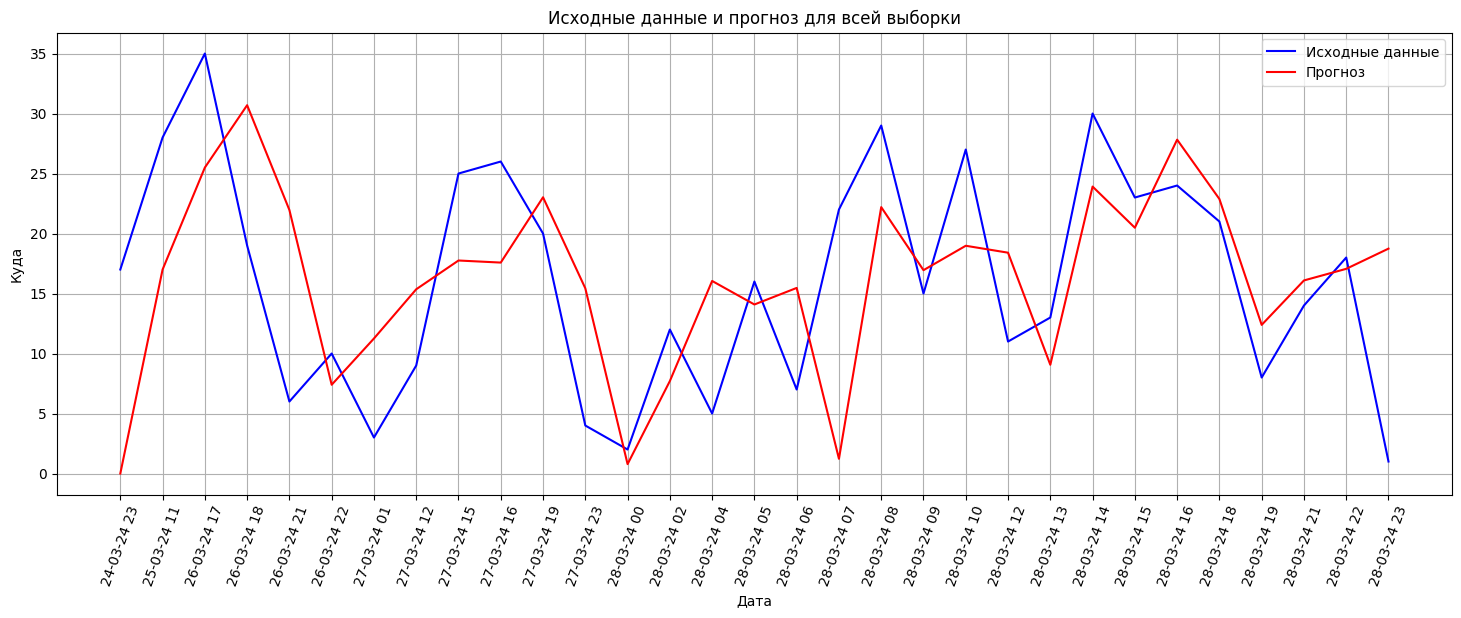

In [114]:
fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

# Рисуем график для исходных данных и прогноза
plt.plot(scaner_to, color='blue', label='Исходные данные') # Исходные данные
plt.plot(preds_all, color='red', label='Прогноз') # Прогноз


plt.title('Исходные данные и прогноз для всей выборки') # Добавляем заголовок графика
plt.legend() # Добавляем легенду
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x
plt.grid() # Добавление сетки на график

plt.show() # Отображение графика

Прогнозирование данных не разделяя их на часы

In [115]:
scaner_to = pd.read_excel('Сканер/LPC_Scaner_Data_To.xlsx') # Считываем данные из xlsx файла

scaner_to['Куда'] = scaner_to['Куда'].str.replace(r'\[.*\]', '', regex=True).str.strip() # Удаляем все, что находится в квадратных скобках

scaner_to['Дата'] = pd.to_datetime(scaner_to['Дата']) # Преобразуем столбец 'Дата' в формат datetime
scaner_to['Дата'] = scaner_to['Дата'].dt.strftime('%y-%m-%d') # Преобразуем 'Дата' в формат 'yy-mm-dd'
scaner_to.set_index('Дата', inplace=True) # Устанавливаем 'Дата' в качестве индекса

scaner_to.head() # Выводим первые 5 строк данных

,Куда
Дата,
28-03-24,АНГЦ3.СГП.100-11
28-03-24,НГП.У.М126
28-03-24,НГП.З-128
28-03-24,НГП.У.И125
28-03-24,НГП.У.М124


In [116]:
scaner_to['count'] = scaner_to.groupby('Дата')['Куда'].count() # Вычисляем количество элементов в группе 'Дата' по столбцу 'Куда'
scaner_to.drop(['Куда'], axis=1, inplace=True) # Удаляем столбец 'Куда'
scaner_to.drop_duplicates(inplace=True) # Удаляем повторяющиеся строки
scaner_to = scaner_to.sort_index(ascending=True) # Сортируем по индексу в возрастающем порядке
scaner_to.head() # Выводим первые 5 строк

,count
Дата,
24-03-24,17
25-03-24,230
26-03-24,309
27-03-24,313
28-03-24,374


In [117]:
# Разделяем набор данных на обучающую часть и тестовую часть
per_len = int(len(scaner_to) * 70 / 100) # Узнаем сколько данных входит в 70 процентов от всех данных

train_to_sc = scaner_to[:per_len] # Обучающая часть
test_to_sc = scaner_to[per_len:] # Тестовая часть

In [118]:
import warnings

warnings.simplefilter(action = 'ignore', category = Warning) # Устанавливаем глобальное значение для игнорирования предупреждений

model_to_sc = ARIMA(train_to_sc, order=(5,1,0)) # Создаем объект модели ARIMA для обучения с заданными гиперпараметрами
model_to_fit = model_to_sc.fit() # Обучаем модель

In [119]:
start = len(train_to_sc) # Сохраняем длину обучающей выборки в переменную start
end = len(train_to_sc) + len(test_to_sc) - 1 # Вычисляем длину выборки после обучения (включая тестовую выборку) и сохраняем это значение в переменную end

pred_to_sc = model_to_fit.predict(start, end) # Прогнозируем значения по обучающей выборке с помощью сохраненного модели и сохраняем прогнозы в переменную predictions_sc

pred_to_sc.index = test_to_sc.index # меняем индекс прогнозов на индекс тестовых значений

pred_to_sc # Выводим прогнозы в виде объекта DataFrame

Дата
27-03-24    518.699982
28-03-24    600.473228
Name: predicted_mean, dtype: float64

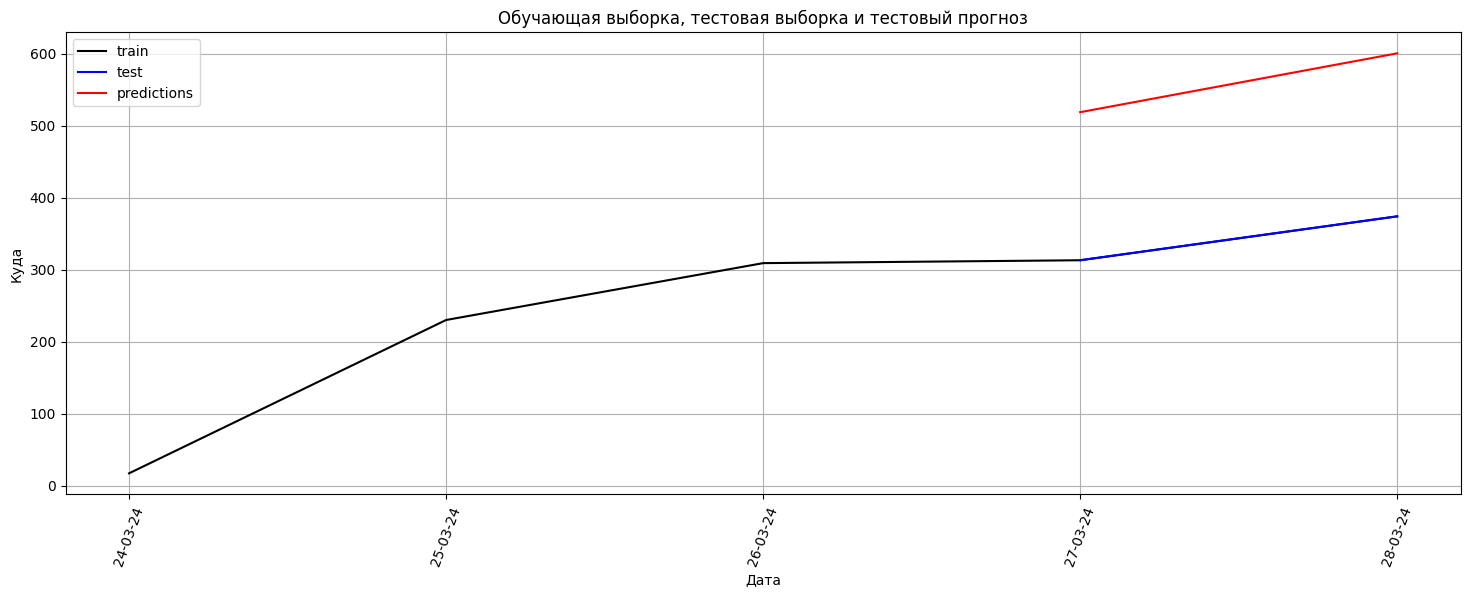

In [120]:
fig = plt.figure(figsize=(18, 6)) # Создаем новый объект Figure с размером 18*6

# Рисуем график для обучающей выборки, тестовой выборки и предсказаний
plt.plot(scaner_to, color='black', label='train') # Обучающая выборка
plt.plot(test_to_sc, color='blue', label='test') # Тестовая выборка
plt.plot(pred_to_sc, color='red', label='predictions') # Тестовый прогноз

plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз') # Добавляем заголовок графика
plt.legend() # Добавляем легенду
plt.ylabel('Куда') # Добавляем метки оси y
plt.xlabel('Дата') # Добавляем метки оси x
plt.xticks(scaner_to.index, rotation=70) # Устанавливаем направление меток на оси x
plt.grid() # Добавление сетки на график

plt.show() # Отображение графика